# Comparison between GoiStrat and naïve solution

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Imports

In [2]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np

from IPython.display import display
from typing import Iterable, Dict
from itertools import product
import matplotlib.pyplot as plt
from pathlib import Path

Setup

In [3]:
src_path: str = "/home/uziel/Development/goi-strat/src"
sys.path.insert(0, src_path)

In [4]:
from data.utils import calculate_power

In [5]:
ROOT: Path = Path("/mnt/d/phd_data/")
MSIGDB_CATS: Iterable[str] = ("H", *[f"C{i}" for i in range(1, 9)])
DATASETS_MARKERS: Dict[str, str] = {
    "TCGA-BRCA": "FOXA1",  # https://www.sciencedirect.com/science/article/abs/pii/S0960977616000242
    "TCGA-LUAD": "NKX2-1",  # https://www.nature.com/articles/nature09881
    "TCGA-THCA": "BRAF",  # https://www.frontiersin.org/journals/endocrinology/articles/10.3389/fendo.2024.1372553/full
    "TCGA-UCEC": "MCM10",  # https://onlinelibrary.wiley.com/doi/full/10.1111/jcmm.17772
    "TCGA-LUSC": "SOX2",  # https://www.cell.com/cancer-cell/fulltext/S1535-6108(16)30436-6
    "TCGA-KIRC": "CA9",  # https://www.sciencedirect.com/science/article/abs/pii/S0959804910006982
    "TCGA-HNSC": "TP63",  # https://aacrjournals.org/mcr/article/17/6/1279/270274/Loss-of-TP63-Promotes-the-Metastasis-of-Head-and
    "TCGA-LGG": "IDH1",  # https://www.neurology.org/doi/abs/10.1212/wnl.0b013e3181f96282
    "PCTA_WCDT": "FOLH1",  # https://www.nature.com/articles/nrurol.2016.26
}
PERCENTILES: Iterable[int] = (10, 15, 20, 25, 30)
RENAME_DICT: Dict = {
    "GOI_level": "GoiStrat",
    "GOI_level_10": "10 / 80 / 10",
    "GOI_level_15": "15 / 70 / 15",
    "GOI_level_20": "20 / 60 / 20",
    "GOI_level_25": "25 / 50 / 25",
    "GOI_level_30": "30 / 40 / 30",
}
SAMPLE_TYPE: str = "prim"
PALETTE_STR: str = "flare"
EFFECT_SIZE: float = 0.5
ALPHA: float = 0.05

sns.set_theme(style="whitegrid", palette=PALETTE_STR)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Ubuntu Mono"
plt.rcParams["font.monospace"] = "Ubuntu Mono"

Global variables

In [6]:
MULTI_DATASET_PATH: Path = ROOT.joinpath("MULTI_DATASET")
MULTI_DATASET_PATH.mkdir(parents=True, exist_ok=True)

## 1. Explore dataset characteristics

### 1.1. Annotation data from GSVA splits

In [7]:
group_counts_gsva = {}
for dataset, marker in DATASETS_MARKERS.items():
    data_root = ROOT.joinpath(f"{dataset}_{marker}")
    annot_df = pd.read_csv(
        data_root.joinpath("data").joinpath(f"samples_annotation_{marker}_gsva.csv"),
        index_col=0,
    )
    group_counts_gsva[dataset + f" ({marker})"] = (
        annot_df[f"{marker}_level"].value_counts().to_dict()
    )
    group_counts_gsva[dataset + f" ({marker})"].update({"total": len(annot_df)})

group_counts_gsva_df = pd.DataFrame(group_counts_gsva).T
group_counts_gsva_df.to_csv(MULTI_DATASET_PATH.joinpath("group_counts_gsva_df.csv"))
display(group_counts_gsva_df)

,mid,high,low,total
TCGA-BRCA (FOXA1),553,330,223,1106
TCGA-LUAD (NKX2-1),264,52,212,528
TCGA-THCA (BRAF),252,194,59,505
TCGA-UCEC (MCM10),274,186,89,549
TCGA-LUSC (SOX2),250,54,197,501
TCGA-KIRC (CA9),268,53,216,537
TCGA-HNSC (TP63),260,61,199,520
TCGA-LGG (IDH1),258,207,51,516
PCTA_WCDT (FOLH1),331,90,241,662


### 1.1. Annotation data from top/bottom splits

In [8]:
group_counts = dict()
for dataset, marker in DATASETS_MARKERS.items():
    data_root = ROOT.joinpath(f"{dataset}_{marker}")
    annot_df = pd.read_csv(
        data_root.joinpath("data").joinpath(f"samples_annotation_{marker}_gsva.csv"),
        index_col=0,
    )
    contrast_factor = f"{marker}_level"
    group_counts[(dataset + f" ({marker})", "GOI_level")] = (
        annot_df[contrast_factor].value_counts().to_dict()
    )
    group_counts[(dataset + f" ({marker})", "GOI_level")].update(
        {"total": len(annot_df)}
    )

    for percentile in PERCENTILES:
        annot_df = pd.read_csv(
            data_root.joinpath("data").joinpath(
                f"samples_annotation_{marker}_perc.csv"
            ),
            index_col=0,
        )
        contrast_factor = f"{marker}_level_{percentile}"
        group_counts[(dataset + f" ({marker})", f"GOI_level_{percentile}")] = (
            annot_df[contrast_factor].value_counts().to_dict()
        )
        group_counts[(dataset + f" ({marker})", f"GOI_level_{percentile}")].update(
            {"total": len(annot_df)}
        )

group_counts_df = pd.DataFrame(group_counts).T
group_counts_df.to_csv(MULTI_DATASET_PATH.joinpath("group_counts_df.csv"))
display(group_counts_df)

mid  high  low  total
TCGA-BRCA (FOXA1)  GOI_level     553   330  223   1106
                   GOI_level_10  884   111  111   1106
                   GOI_level_15  774   166  166   1106
                   GOI_level_20  664   221  221   1106
                   GOI_level_25  552   277  277   1106
                   GOI_level_30  442   332  332   1106
TCGA-LUAD (NKX2-1) GOI_level     264    52  212    528
                   GOI_level_10  422    53   53    528
                   GOI_level_15  368    80   80    528
                   GOI_level_20  316   106  106    528
                   GOI_level_25  264   132  132    528
                   GOI_level_30  210   159  159    528
TCGA-THCA (BRAF)   GOI_level     252   194   59    505
                   GOI_level_10  403    51   51    505
                   GOI_level_15  353    76   76    505
                   GOI_level_20  303   101  101    505
                   GOI_level_25  253   126  126    505
                   GOI_level_30  201   152  152    505
TCGA-UCEC (MCM10)  GOI_level     274   186   89    549
                   GOI_level_10  439    55   55    549
                   GOI_level_15  383    83   83    549
                   GOI_level_20  329   110  110    549
                   GOI_level_25  275   137  137    549
                   GOI_level_30  219   165  165    549
TCGA-LUSC (SOX2)   GOI_level     250    54  197    501
                   GOI_level_10  401    50   50    501
                   GOI_level_15  351    75   75    501
                   GOI_level_20  301   100  100    501
                   GOI_level_25  251   125  125    501
                   GOI_level_30  201   150  150    501
TCGA-KIRC (CA9)    GOI_level     268    53  216    537
                   GOI_level_10  429    54   54    537
                   GOI_level_15  375    81   81    537
                   GOI_level_20  321   108  108    537
                   GOI_level_25  269   134  134    537
                   GOI_level_30  215   161  161    537
TCGA-HNSC (TP63)   GOI_level     260    61  199    520
                   GOI_level_10  416    52   52    520
                   GOI_level_15  364    78   78    520
                   GOI_level_20  312   104  104    520
                   GOI_level_25  260   130  130    520
                   GOI_level_30  208   156  156    520
TCGA-LGG (IDH1)    GOI_level     258   207   51    516
                   GOI_level_10  412    52   52    516
                   GOI_level_15  360    78   78    516
                   GOI_level_20  310   103  103    516
                   GOI_level_25  258   129  129    516
                   GOI_level_30  206   155  155    516
PCTA_WCDT (FOLH1)  GOI_level     331    90  241    662
                   GOI_level_10  528    67   67    662
                   GOI_level_15  462   100  100    662
                   GOI_level_20  396   133  133    662
                   GOI_level_25  330   166  166    662
                   GOI_level_30  264   199  199    662

In [9]:
# Function to apply calculate_power to each row
def calculate_row_power(row: pd.Series) -> float:
    """
    Calculate the test power for a given row using the low and high values.

    Parameters:
    - row: A pandas Series representing a row of the DataFrame.

    Returns:
    - float: The calculated power for the row.
    """
    return calculate_power(
        effect_size=EFFECT_SIZE, alpha=ALPHA, n1=row["low"], n2=row["high"]
    )


# Apply the function to each row and create a new column 'power'
group_counts_df["power"] = group_counts_df.apply(calculate_row_power, axis=1)

# Display the updated DataFrame
display(group_counts_df)

mid  high  low  total     power
TCGA-BRCA (FOXA1)  GOI_level     553   330  223   1106  0.999927
                   GOI_level_10  884   111  111   1106  0.959824
                   GOI_level_15  774   166  166   1106  0.995088
                   GOI_level_20  664   221  221   1106  0.999489
                   GOI_level_25  552   277  277   1106  1.000000
                   GOI_level_30  442   332  332   1106  1.000000
TCGA-LUAD (NKX2-1) GOI_level     264    52  212    528  0.896017
                   GOI_level_10  422    53   53    528  0.722445
                   GOI_level_15  368    80   80    528  0.881602
                   GOI_level_20  316   106  106    528  0.951883
                   GOI_level_25  264   132  132    528  0.981561
                   GOI_level_30  210   159  159    528  0.993515
TCGA-THCA (BRAF)   GOI_level     252   194   59    505  0.917768
                   GOI_level_10  403    51   51    505  0.705613
                   GOI_level_15  353    76   76    505  0.864867
                   GOI_level_20  303   101  101    505  0.942498
                   GOI_level_25  253   126  126    505  0.976890
                   GOI_level_30  201   152  152    505  0.991461
TCGA-UCEC (MCM10)  GOI_level     274   186   89    549  0.971653
                   GOI_level_10  439    55   55    549  0.738487
                   GOI_level_15  383    83   83    549  0.892908
                   GOI_level_20  329   110  110    549  0.958341
                   GOI_level_25  275   137  137    549  0.984753
                   GOI_level_30  219   165  165    549  0.994888
TCGA-LUSC (SOX2)   GOI_level     250    54  197    501  0.900175
                   GOI_level_10  401    50   50    501  0.696893
                   GOI_level_15  351    75   75    501  0.860368
                   GOI_level_20  301   100  100    501  0.940427
                   GOI_level_25  251   125  125    501  0.976009
                   GOI_level_30  201   150  150    501  0.990768
TCGA-KIRC (CA9)    GOI_level     268    53  216    537  0.901491
                   GOI_level_10  429    54   54    537  0.730564
                   GOI_level_15  375    81   81    537  0.885485
                   GOI_level_20  321   108  108    537  0.955221
                   GOI_level_25  269   134  134    537  0.982908
                   GOI_level_30  215   161  161    537  0.994008
TCGA-HNSC (TP63)   GOI_level     260    61  199    520  0.925594
                   GOI_level_10  416    52   52    520  0.714129
                   GOI_level_15  364    78   78    520  0.873482
                   GOI_level_20  312   104  104    520  0.948315
                   GOI_level_25  260   130  130    520  0.980114
                   GOI_level_30  208   156  156    520  0.992701
TCGA-LGG (IDH1)    GOI_level     258   207   51    516  0.889976
                   GOI_level_10  412    52   52    516  0.714129
                   GOI_level_15  360    78   78    516  0.873482
                   GOI_level_20  310   103  103    516  0.946439
                   GOI_level_25  258   129  129    516  0.979351
                   GOI_level_30  206   155  155    516  0.992408
PCTA_WCDT (FOLH1)  GOI_level     331    90  241    662  0.981038
                   GOI_level_10  528    67   67    662  0.819348
                   GOI_level_15  462   100  100    662  0.940427
                   GOI_level_20  396   133  133    662  0.982247
                   GOI_level_25  330   166  166    662  0.995088
                   GOI_level_30  264   199  199    662  0.998717

In [10]:
power_map = group_counts_df["power"].to_dict()
print(power_map)

{('TCGA-BRCA (FOXA1)', 'GOI_level'): 0.999927005739882, ('TCGA-BRCA (FOXA1)', 'GOI_level_10'): 0.9598236158634741, ('TCGA-BRCA (FOXA1)', 'GOI_level_15'): 0.9950879206127476, ('TCGA-BRCA (FOXA1)', 'GOI_level_20'): 0.9994891339216804, ('TCGA-BRCA (FOXA1)', 'GOI_level_25'): 1.0, ('TCGA-BRCA (FOXA1)', 'GOI_level_30'): 1.0, ('TCGA-LUAD (NKX2-1)', 'GOI_level'): 0.8960165794812585, ('TCGA-LUAD (NKX2-1)', 'GOI_level_10'): 0.7224452892573963, ('TCGA-LUAD (NKX2-1)', 'GOI_level_15'): 0.8816024847721196, ('TCGA-LUAD (NKX2-1)', 'GOI_level_20'): 0.9518832387085298, ('TCGA-LUAD (NKX2-1)', 'GOI_level_25'): 0.9815614364531526, ('TCGA-LUAD (NKX2-1)', 'GOI_level_30'): 0.9935148960423404, ('TCGA-THCA (BRAF)', 'GOI_level'): 0.9177684041766646, ('TCGA-THCA (BRAF)', 'GOI_level_10'): 0.7056125740521042, ('TCGA-THCA (BRAF)', 'GOI_level_15'): 0.8648673142097211, ('TCGA-THCA (BRAF)', 'GOI_level_20'): 0.9424975311351828, ('TCGA-THCA (BRAF)', 'GOI_level_25'): 0.9768896517490835, ('TCGA-THCA (BRAF)', 'GOI_level_30'

## 2. Gather and compare differential expression results

Differential expression results between low and high groups for each dataset and splitting strategy.

In [11]:
all_degs = dict()
all_degs_scores = dict()
for dataset, marker in DATASETS_MARKERS.items():
    contrast_factors = [
        f"{marker}_level_{percentile}" for percentile in PERCENTILES
    ] + [f"{marker}_level"]
    data_root = ROOT.joinpath(f"{dataset}_{marker}")

    for contrast_factor in contrast_factors:
        deseq_results = pd.read_csv(
            data_root.joinpath("deseq2").joinpath(
                f"sample_type_{SAMPLE_TYPE}_{contrast_factor}_"
                f"{SAMPLE_TYPE}_high+{SAMPLE_TYPE}_low_"
                f"_{SAMPLE_TYPE}_high_vs_{SAMPLE_TYPE}_low_"
                "padj_0_05_all_1_0_deseq_results_unique.csv"
            ),
            index_col=0,
        )
        contrast_factor_str = contrast_factor.replace(marker, "GOI")
        all_degs[(dataset + f" ({marker})", contrast_factor_str)] = deseq_results[
            "log2FoldChange"
        ]
        all_degs_scores[(dataset + f" ({marker})", contrast_factor_str)] = (
            deseq_results["log2FoldChange"].pipe(
                lambda x: np.sqrt(np.mean(np.power(x, 2)))
            )
        )

all_degs_df = pd.DataFrame(all_degs)

In [12]:
all_degs_scores_df = pd.Series(all_degs_scores).unstack(level=0).transpose()
all_degs_scores_df.to_csv(MULTI_DATASET_PATH.joinpath("all_degs_scores_df.csv"))
display(all_degs_scores_df)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),1.523208,1.724276,1.597775,1.571454,1.508589,1.479444
TCGA-BRCA (FOXA1),2.432425,2.733373,2.650776,2.514013,2.306919,2.197974
TCGA-HNSC (TP63),1.483313,1.598803,1.541048,1.481256,1.474818,1.442893
TCGA-KIRC (CA9),1.896113,2.267806,2.327118,2.354664,2.323584,2.206625
TCGA-LGG (IDH1),1.781794,1.878264,1.786128,1.681172,1.612114,1.537598
TCGA-LUAD (NKX2-1),1.947659,2.276284,2.178660,2.110323,2.083919,2.007937
TCGA-LUSC (SOX2),1.795002,1.999208,1.926709,1.873019,1.822779,1.799866
TCGA-THCA (BRAF),1.492055,1.825604,1.674442,1.642668,1.621172,1.623575
TCGA-UCEC (MCM10),1.880049,2.070832,2.019452,1.957810,1.916015,1.817026


In [13]:
def apply_function(df, func):
    for row_idx, row in df.iterrows():
        for col_idx, value in row.items():
            df.at[row_idx, col_idx] = value * func[(row_idx, col_idx)]
    return df


all_degs_scores_df_weighted = apply_function(all_degs_scores_df, power_map)
all_degs_scores_df_weighted.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted.csv")
)
display(all_degs_scores_df_weighted)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),1.494325,1.412781,1.502591,1.543556,1.501179,1.477546
TCGA-BRCA (FOXA1),2.432248,2.623556,2.637755,2.512729,2.306919,2.197974
TCGA-HNSC (TP63),1.372945,1.141752,1.346077,1.404697,1.445491,1.432361
TCGA-KIRC (CA9),1.709328,1.656777,2.060628,2.249224,2.283869,2.193403
TCGA-LGG (IDH1),1.585753,1.341323,1.560151,1.591127,1.578825,1.525925
TCGA-LUAD (NKX2-1),1.745135,1.644491,1.920712,2.008781,2.045494,1.994915
TCGA-LUSC (SOX2),1.615815,1.393235,1.657678,1.761438,1.779049,1.783249
TCGA-THCA (BRAF),1.369361,1.288169,1.448170,1.548211,1.583706,1.609711
TCGA-UCEC (MCM10),1.826757,1.529282,1.803185,1.876249,1.886802,1.807738


In [14]:
all_degs_scores_df_weighted_ranked = all_degs_scores_df_weighted.rank(
    axis=1, method="max", ascending=False
).astype(int)
all_degs_scores_df_weighted_ranked.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted_ranked.csv")
)
display(all_degs_scores_df_weighted_ranked)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),4,6,2,1,3,5
TCGA-BRCA (FOXA1),4,2,1,3,5,6
TCGA-HNSC (TP63),4,6,5,3,1,2
TCGA-KIRC (CA9),5,6,4,2,1,3
TCGA-LGG (IDH1),2,6,4,1,3,5
TCGA-LUAD (NKX2-1),5,6,4,2,1,3
TCGA-LUSC (SOX2),5,6,4,3,2,1
TCGA-THCA (BRAF),5,6,4,3,2,1
TCGA-UCEC (MCM10),3,6,5,2,1,4


In [15]:
all_degs_scores_df_weighted_ranked_summary = (
    all_degs_scores_df_weighted_ranked.median().sort_values(ascending=True)
)
all_degs_scores_df_weighted_ranked_summary.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted_ranked_summary.csv")
)
display(all_degs_scores_df_weighted_ranked_summary)

GOI_level_20    2.0
GOI_level_25    2.0
GOI_level_30    3.0
GOI_level       4.0
GOI_level_15    4.0
GOI_level_10    6.0
dtype: float64

### 2.1. Visualise results

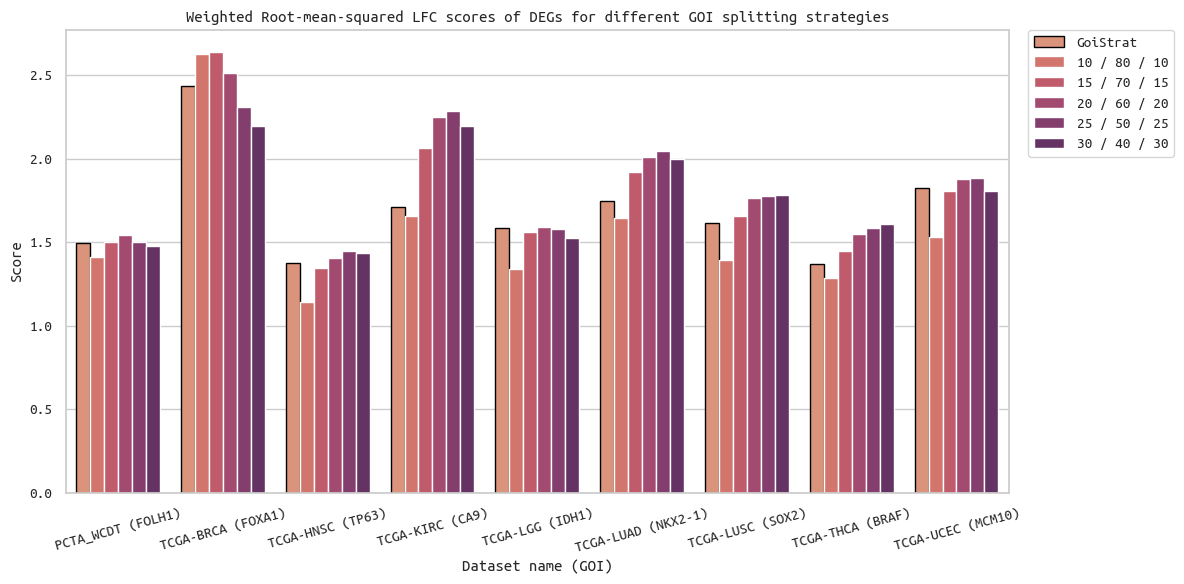

In [16]:
# Melt the DataFrame to long format for seaborn
all_degs_scores_df_weighted_melted = all_degs_scores_df_weighted.reset_index().melt(
    id_vars="index", var_name="Column", value_name="Score"
)

all_degs_scores_df_weighted_melted["Column"] = all_degs_scores_df_weighted_melted[
    "Column"
].map(RENAME_DICT)

# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=all_degs_scores_df_weighted_melted,
    x="index",
    y="Score",
    hue="Column",
    palette=PALETTE_STR,
)

# Customize the plot
plt.xticks(rotation=15)
plt.xlabel("Dataset name (GOI)")
plt.ylabel("Score")
plt.title(
    "Weighted Root-mean-squared LFC scores of DEGs for different GOI splitting strategies"
)

# Add a black border to the bar corresponding to "GOI_level"
for patch, level in zip(barplot.patches, all_degs_scores_df_weighted_melted["Column"]):
    if level == "GoiStrat":
        patch.set_edgecolor("black")
        patch.set_linewidth(1)

# Move the legend outside of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)

# Show the plot
plt.tight_layout()
plt.show()

## 3. Gather and compare differential enrichment results

Differential enrichment results between low and high groups for each dataset and splitting strategy.

In [17]:
all_degss = dict()
all_degss_scores = dict()
for dataset, marker in DATASETS_MARKERS.items():
    contrast_factors = [
        f"{marker}_level_{percentile}" for percentile in PERCENTILES
    ] + [f"{marker}_level"]
    data_root = ROOT.joinpath(f"{dataset}_{marker}")
    msigdb_cats_meta_dfs = {
        msigdb_cat: pd.read_csv(
            ROOT.joinpath(dataset)
            .joinpath("data")
            .joinpath("gsva")
            .joinpath(f"{msigdb_cat}_meta.csv"),
            index_col=0,
        )
        for msigdb_cat in MSIGDB_CATS
    }

    for contrast_factor, msigdb_cat in product(contrast_factors, MSIGDB_CATS):
        gsva_results = pd.read_csv(
            data_root.joinpath("diff_gsva")
            .joinpath(msigdb_cat)
            .joinpath(
                f"sample_type_{SAMPLE_TYPE}_{contrast_factor}_"
                f"{SAMPLE_TYPE}_high+{SAMPLE_TYPE}_low_"
                f"_{SAMPLE_TYPE}_high_vs_{SAMPLE_TYPE}_low_"
                "top_table_padj_0_05_all_0_0.csv"
            ),
            index_col=0,
        )
        contrast_factor_str = contrast_factor.replace(marker, "GOI")
        all_degss[(dataset + f" ({marker})", contrast_factor_str, msigdb_cat)] = (
            gsva_results["log2FoldChange"]
        )
        all_degss_scores[
            (dataset + f" ({marker})", contrast_factor_str, msigdb_cat)
        ] = gsva_results["log2FoldChange"].pipe(
            lambda x: (x.count() / len(msigdb_cats_meta_dfs[msigdb_cat]))
            * np.sqrt(np.mean(np.power(x, 2)))
        )

all_degss_df = pd.DataFrame(all_degss)

In [18]:
all_degss_scores_df = (
    pd.Series(all_degss_scores).unstack(level=[0, 1]).median().unstack()
)
all_degss_scores_df.to_csv(MULTI_DATASET_PATH.joinpath("all_degss_scores_df.csv"))
display(all_degss_scores_df)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),0.142125,0.133210,0.137942,0.131065,0.122510,0.108408
TCGA-BRCA (FOXA1),0.154515,0.170450,0.170926,0.162655,0.145538,0.134819
TCGA-HNSC (TP63),0.099136,0.097009,0.091157,0.092526,0.084081,0.081235
TCGA-KIRC (CA9),0.098297,0.110873,0.094056,0.086699,0.082785,0.079951
TCGA-LGG (IDH1),0.125393,0.140012,0.124962,0.111795,0.101627,0.092250
TCGA-LUAD (NKX2-1),0.105013,0.101345,0.089102,0.088880,0.089804,0.086732
TCGA-LUSC (SOX2),0.147486,0.163678,0.149648,0.130866,0.122489,0.118642
TCGA-THCA (BRAF),0.165678,0.173495,0.171389,0.168645,0.159379,0.153225
TCGA-UCEC (MCM10),0.171470,0.194194,0.188377,0.176342,0.164723,0.153989


In [19]:
def apply_function(df, func):
    for row_idx, row in df.iterrows():
        for col_idx, value in row.items():
            df.at[row_idx, col_idx] = value * func[(row_idx, col_idx)]
    return df


all_degss_scores_df_weighted = apply_function(all_degss_scores_df, power_map)
all_degss_scores_df_weighted.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted.csv")
)
display(all_degss_scores_df_weighted)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),0.139430,0.109146,0.129724,0.128738,0.121908,0.108269
TCGA-BRCA (FOXA1),0.154504,0.163602,0.170087,0.162572,0.145538,0.134819
TCGA-HNSC (TP63),0.091760,0.069277,0.079624,0.087744,0.082409,0.080642
TCGA-KIRC (CA9),0.088614,0.081000,0.083285,0.082816,0.081370,0.079472
TCGA-LGG (IDH1),0.111597,0.099987,0.109152,0.105807,0.099529,0.091550
TCGA-LUAD (NKX2-1),0.094093,0.073216,0.078552,0.084604,0.088148,0.086169
TCGA-LUSC (SOX2),0.132763,0.114066,0.128752,0.123070,0.119550,0.117547
TCGA-THCA (BRAF),0.152054,0.122421,0.148229,0.158948,0.155696,0.151917
TCGA-UCEC (MCM10),0.166609,0.143409,0.168204,0.168996,0.162211,0.153202


In [20]:
all_degss_scores_df_weighted_ranked = all_degss_scores_df_weighted.rank(
    axis=1, method="max", ascending=False
).astype(int)
all_degss_scores_df_weighted_ranked.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_ranked.csv")
)
display(all_degss_scores_df_weighted_ranked)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA_WCDT (FOLH1),1,5,2,3,4,6
TCGA-BRCA (FOXA1),4,2,1,3,5,6
TCGA-HNSC (TP63),1,6,5,2,3,4
TCGA-KIRC (CA9),1,5,2,3,4,6
TCGA-LGG (IDH1),1,4,2,3,5,6
TCGA-LUAD (NKX2-1),1,6,5,4,2,3
TCGA-LUSC (SOX2),1,6,2,3,4,5
TCGA-THCA (BRAF),3,6,5,1,2,4
TCGA-UCEC (MCM10),3,6,2,1,4,5


In [21]:
all_degss_scores_df_weighted_ranked_summary = (
    all_degss_scores_df_weighted_ranked.median().sort_values(ascending=True)
)
all_degss_scores_df_weighted_ranked_summary.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_ranked_summary.csv")
)
display(all_degss_scores_df_weighted_ranked_summary)

GOI_level       1.0
GOI_level_15    2.0
GOI_level_20    3.0
GOI_level_25    4.0
GOI_level_30    5.0
GOI_level_10    6.0
dtype: float64

### 3.1. Visualise results

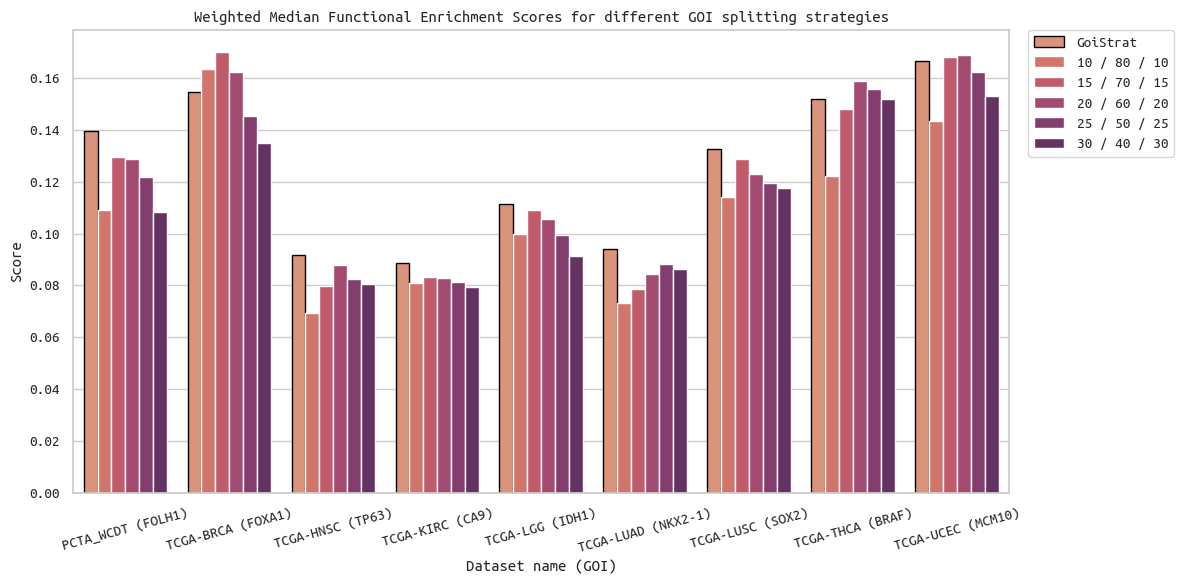

In [22]:
# Melt the DataFrame to long format for seaborn
all_degss_scores_df_weighted_melted = all_degss_scores_df_weighted.reset_index().melt(
    id_vars="index", var_name="Column", value_name="Score"
)

all_degss_scores_df_weighted_melted["Column"] = all_degss_scores_df_weighted_melted[
    "Column"
].map(RENAME_DICT)

# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=all_degss_scores_df_weighted_melted,
    x="index",
    y="Score",
    hue="Column",
    palette=PALETTE_STR,
)

# Customize the plot
plt.xticks(rotation=15)
plt.xlabel("Dataset name (GOI)")
plt.ylabel("Score")
plt.title(
    "Weighted Median Functional Enrichment Scores for different GOI splitting strategies"
)

# Add a black border to the bar corresponding to "GOI_level"
for patch, level in zip(barplot.patches, all_degss_scores_df_weighted_melted["Column"]):
    if level == "GoiStrat":
        patch.set_edgecolor("black")
        patch.set_linewidth(1)

# Move the legend outside of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)

# Show the plot
plt.tight_layout()
plt.show()

- Median functional difference scores have been weighted by the power of the differential analysis test for a fairer comparison.
- We can observe a considerable heterogenity in the ability of each method to successfully split the samples such that the functional differences are maximised. In spite of this, the GoiStrat method demonstrates a higher consistency in its ability to identify functional differences between the high and low groups.
- It ranks first in 6 out of 9 datasets, and a close third in other two.